In [347]:
import pandas as pd
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

   OBJECTID          Oceans Regions SubRegions  Sampling Method  Measurement  \
0      9676  Atlantic Ocean     NaN        NaN      Grab sample        0.018   
1      6427   Pacific Ocean     NaN        NaN      Neuston net        0.000   
2     10672   Pacific Ocean     NaN        NaN        Manta net        0.013   
3     13921  Atlantic Ocean     NaN        NaN  Aluminum bucket     1368.000   
4      9344   Pacific Ocean     NaN        NaN      Grab sample        0.001   

        Unit Density Range Density Class       Short Reference  ...  \
0  pieces/m3       0.005-1        Medium    Barrows et al.2018  ...   
1  pieces/m3      0-0.0005      Very Low        Law et al.2014  ...   
2  pieces/m3       0.005-1        Medium  Goldstein et al.2013  ...   
3  pieces/m3          >=10     Very High    Queiroz et al.2022  ...   
4  pieces/m3  0.0005-0.005           Low    Barrows et al.2018  ...   

                                        Organization  \
0                                Adv

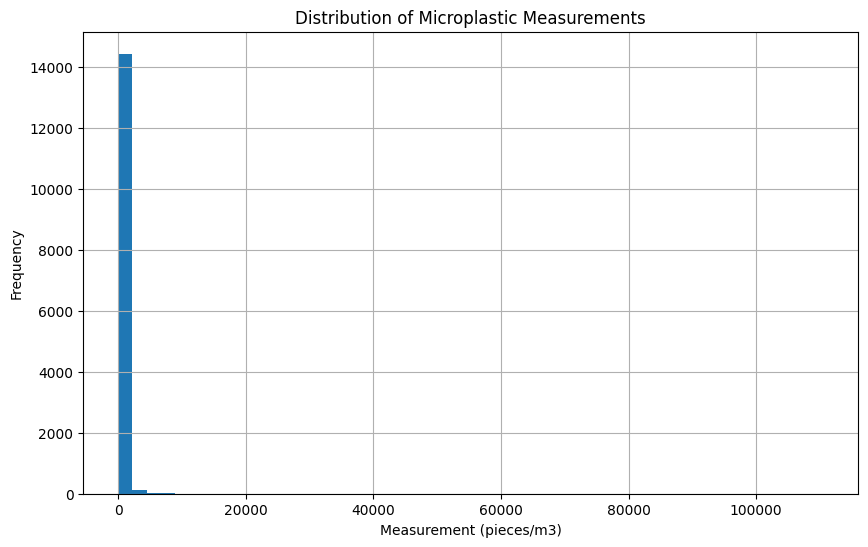

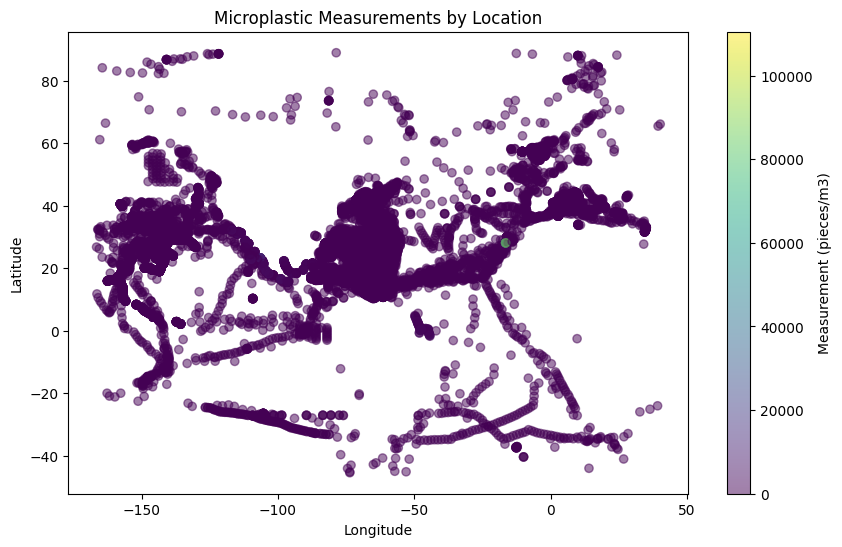

In [348]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "/Users/williamzebrowski/mlx/data/Marine_Microplastics.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

# Basic statistics
print(data.describe())

# Distribution of measurements by ocean
data.groupby('Oceans')['Measurement'].describe()

# Plot the distribution of measurements
plt.figure(figsize=(10, 6))
data['Measurement'].hist(bins=50)
plt.title('Distribution of Microplastic Measurements')
plt.xlabel('Measurement (pieces/m3)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of measurements by location
plt.figure(figsize=(10, 6))
plt.scatter(data['Longitude'], data['Latitude'], c=data['Measurement'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Measurement (pieces/m3)')
plt.title('Microplastic Measurements by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

1. Predicting Microplastic Density Class

	•	Goal: Predict the density class (e.g., Very Low, Low, Medium, High, Very High) based on features like ocean, region, sampling method, and location.

2. Clustering Locations by Pollution Levels

	•	Goal: Cluster different locations based on their microplastic concentrations to identify pollution hotspots and patterns.

3. Analyzing Spatial Distribution

	•	Goal: Analyze the spatial distribution of microplastic pollution to understand geographical patterns and trends.

Example: Predicting Microplastic Density Class

Here’s how you can predict the microplastic density class using the available features:

	1.	Data Preparation:
		• Handle missing values.
		• Encode categorical variables.
		• Standardize numerical features.
	2.	Model Training:
		•Train a classification model to predict the density class.

Sample Code for Predicting Microplastic Density Class

In [349]:
# Preprocessing
# Drop rows with missing values
data.dropna(inplace=True)

# Remove non-numeric columns
non_numeric_cols = ['Measurement', 'Short Reference', 'Organization', 'Keywords', 'Accession Number', 'Accession Link', 'Date', 'GlobalID', 'x', 'y']
data.drop(non_numeric_cols, axis=1, inplace=True)

# Encode categorical variables
data = pd.get_dummies(data, columns=['Oceans', 'Regions', 'SubRegions', 'Sampling Method'], drop_first=True)

# Features and target variable
X = data.drop('Density Class', axis=1)
y = data['Density Class']

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)  # Fill any remaining NaNs with 0

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Compute class weights for imbalanced data
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=label_encoder.classes_, y=y)
class_weights_mx = mx.array(class_weights)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to MLX arrays
X_train_mx = mx.array(X_train_scaled)
X_test_mx = mx.array(X_test_scaled)
y_train_mx = mx.array(y_train)
y_test_mx = mx.array(y_test)


In [350]:
# Define the model with more layers, batch normalization, dropout, and L2 regularization
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, output_dim)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [351]:
model = MLP(X_train_mx.shape[1], 256, 5)  # Increased hidden_dim to 256

In [354]:
# Loss function with class weights and L2 regularization
def loss_fn(model, X, y):
    logits = model(X)
    l2_reg = 0.001 * sum([mx.sum(param ** 2) for param in model.parameters() if param.requires_grad])
    return mx.mean(nn.losses.cross_entropy(logits, y, weights=class_weights_mx[y])) + l2_reg

loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
optimizer = optim.Adam(model.parameters(), learning_rate=0.001)  # Using Adam optimizer

TypeError: Adam.__init__() got multiple values for argument 'learning_rate'

In [ ]:
# Training loop with early stopping
best_accuracy = 0
patience = 10
patience_counter = 0

for epoch in range(3000):  # Increased the number of epochs
    loss, grads = loss_and_grad_fn(model, X_train_mx, y_train_mx)
    optimizer.update(model, grads)
    mx.eval(model.parameters(), optimizer.state)
    
    if epoch % 10 == 0:
        model.eval()
        predictions = model(X_test_mx)
        accuracy = (predictions.argmax(axis=1) == y_test_mx).sum() / y_test_mx.size
        accuracy = accuracy.item()  # Convert to native Python float
        print(f'Epoch [{epoch+1}/3000], Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')
        
        # Early stopping check
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter > patience:
            print("Early stopping triggered")
            break

Epoch [1/3000], Loss: 1.81700599193573, Accuracy: 9.16%
Epoch [11/3000], Loss: 1.631231665611267, Accuracy: 9.16%
Epoch [21/3000], Loss: 1.6272847652435303, Accuracy: 10.69%
Epoch [31/3000], Loss: 1.6233645677566528, Accuracy: 11.45%
Epoch [41/3000], Loss: 1.6194676160812378, Accuracy: 12.21%
Epoch [51/3000], Loss: 1.6155918836593628, Accuracy: 13.36%
Epoch [61/3000], Loss: 1.6117382049560547, Accuracy: 14.89%
Epoch [71/3000], Loss: 1.6079089641571045, Accuracy: 16.41%
Epoch [81/3000], Loss: 1.6041022539138794, Accuracy: 16.41%
Epoch [91/3000], Loss: 1.6003162860870361, Accuracy: 18.70%
Epoch [101/3000], Loss: 1.5965499877929688, Accuracy: 19.08%
Epoch [111/3000], Loss: 1.5928032398223877, Accuracy: 19.47%
Epoch [121/3000], Loss: 1.5890713930130005, Accuracy: 22.90%
Epoch [131/3000], Loss: 1.5853546857833862, Accuracy: 22.90%
Epoch [141/3000], Loss: 1.5816556215286255, Accuracy: 22.90%
Epoch [151/3000], Loss: 1.5779762268066406, Accuracy: 23.28%
Epoch [161/3000], Loss: 1.57431578636169

In [ ]:
# Final evaluation after training
model.eval()
predictions = model(X_test_mx)
accuracy = (predictions.argmax(axis=1) == y_test_mx).sum() / y_test_mx.size
accuracy = accuracy.item()  # Convert to native Python float
print(f'Final Accuracy: {accuracy * 100:.2f}%')

Final Accuracy: 53.44%
